### Baseline

threshold on the dnbr? 

In [1]:
import rasterio as rio
from rasterio.fill import fillnodata
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import inpaint
from scipy import ndimage


In [4]:
in_file = 'KENNETH_20250109_event.tif'
out_file = 'KENNETH_20250109_interpolated.tif'

In [5]:
with rio.open(in_file) as img:
    data = img.read().astype(np.float32)
    profile = img.profile
    data[data == img.nodata] = np.nan

filled_data = np.zeros_like(data)

for idx in range(data.shape[0]):
    band = data[idx,:, :].copy()
    mask = np.isnan(band)  # True is nan
    if np.any(mask):
        # Replace nan with nearest non-nan values
        indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        band = band[tuple(indices)]
    filled_data[idx] = band 

profile.update(dtype=rio.float32, nodata=np.nan)

with rio.open(out_file, 'w', **profile) as out:
    out.write(filled_data)

SENTINEL-2 data are acquired on 13 spectral bands in the visible and near-infrared (VNIR) and Short-wavelength infrared (SWIR) spectrum, as show in the below table:

| Band name | Resolution (m) | Central wavelength (nm) | Band width (nm) | Purpose |
|-----------|----------------|-------------------------|-----------------|---------|
|B02|10|490|65|Blue|
|B03|10|560|35|Green|
|B04|10|665|30|Red|
|B08|10|842|115|Near infrared|
|B12|20|2190|180|Snow / ice / cloud discrimination|


Bands in the Tiff data are 'B2', 'B3', 'B4', 'B8', 'B12'

#### Band normlization

https://github.com/allenai/satlas/blob/main/Normalization.md

In [6]:
data.shape
filled_data.shape

(5, 206, 239)

In [7]:
np.isnan(filled_data)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
with rio.open(out_file) as f:
    bands = f.read()
    norm_data = np.zeros_like(bands)
    for i in range(bands.shape[0]):
        print(f"Max in origin band {i}: {np.max(bands[i])}, Min in origin band {i}: {np.min(bands[i])}")
        # Perform per-band normalization
        norm_data[i] = (bands[i] - np.min(bands[i])) / (np.max(bands[i]) - np.min(bands[i]))
        print(f"Max in normalized band {i}: {np.max(norm_data[i])}, Min in normalized band {i}: {np.min(norm_data[i])}")


Max in origin band 0: 5040.0, Min in origin band 0: 57.0
Max in normalized band 0: 1.0, Min in normalized band 0: 0.0
Max in origin band 1: 5124.0, Min in origin band 1: 90.0
Max in normalized band 1: 1.0, Min in normalized band 1: 0.0
Max in origin band 2: 5328.0, Min in origin band 2: 88.0
Max in normalized band 2: 1.0, Min in normalized band 2: 0.0
Max in origin band 3: 6194.0, Min in origin band 3: 392.0
Max in normalized band 3: 1.0, Min in normalized band 3: 0.0
Max in origin band 4: 4787.0, Min in origin band 4: 398.0
Max in normalized band 4: 1.0, Min in normalized band 4: 0.0


In [11]:
mask_file = r"KENNETH_20250109_mask.tif"

In [12]:
with rio.open(mask_file) as m:
    mask = m.read()

In [13]:
mask.squeeze().shape

(206, 239)

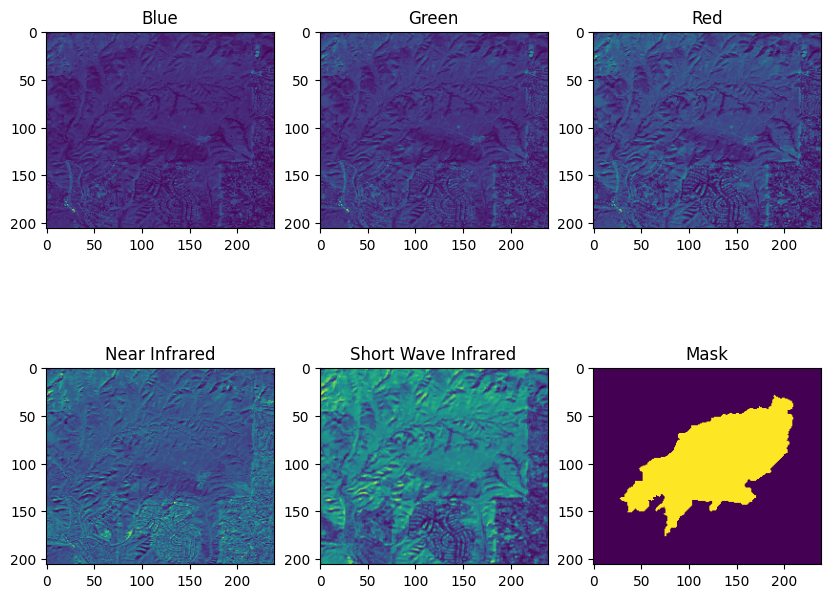

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax[0, 0].imshow(norm_data[0], )
ax[0, 0].set_title("Blue")
ax[0, 1].imshow(norm_data[1])
ax[0, 1].set_title("Green")
ax[0, 2].imshow(norm_data[2])
ax[0, 2].set_title("Red")
ax[1, 0].imshow(norm_data[3])
ax[1, 0].set_title("Near Infrared")
ax[1, 1].imshow(norm_data[4])
ax[1, 1].set_title("Short Wave Infrared")
ax[1, 2].imshow(mask[0])
ax[1, 2].set_title("Mask")    # 0 is the background
plt.show()

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import random
import satlaspretrain_models

#### Process dataset

In [2]:
img_dir = r'data/post_fire'
mask_dir = r'data/masks'
dnbr_dire = r'data/dnbr'

In [17]:
data = os.listdir(img_dir)

In [3]:
def split_dataset(img_dir, train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1, seed = 42):
    data = os.listdir(img_dir)
    data_size = len(data)

    train_size = int(data_size * train_ratio)
    val_size = int(data_size * val_ratio)
    test_size = int(data_size * test_ratio)
    print(f"Training data size {train_size}, Validation data size {val_size}, Testing data size {test_size}")
    
    # Shuffle all images and split into three subsets
    random.seed(seed)
    random.shuffle(data)
    train_data = data[:train_size]
    val_data = data[train_size : train_size+val_size]
    test_data = data[train_size+val_size : data_size]

    return train_data, val_data, test_data

In [4]:
train_data, val_data, test_data = split_dataset(img_dir=img_dir)

Training data size 8, Validation data size 1, Testing data size 1


In [ ]:
class FireDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_list, transforms):
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir   # 0, 1 unburned or burned
        self.img_list = img_list
        self.transforms = transforms
    
    def __len__(self):
        return len(self.img_list)

    def fillnan(self, data):
        filled_data = np.zeros_like(data)

        for idx in range(data.shape[0]):
            band = data[idx,:, :].copy()
            mask = np.isnan(band)  # True is nan
            if np.any(mask):
                # Replace nan with nearest non-nan values
                indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
                band = band[tuple(indices)]
            filled_data[idx] = band 
        
        return filled_data

    def __getitem__(self, idx):
        file_name = self.img_list[idx]

        img_path = os.path.join(self.img_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        with rio.open(img_path) as img:
            img_data = img.read().astype(np.float32)
            profile = img.profile
            img_data[img_data == img.nodata] = np.nan
            img = self.fillnan(img_path)
        with rio.open(mask_path) as mask:
            mask_data = mask.read()
        
        img_tensor = torch.from_numpy(img_data).float()
        mask_tensor = torch.from_numpy(mask_data).long().squeeze()

        if self.transform:
            img_tensor = self.transform(img_tensor)
            
        return img_tensor, mask_tensor


In [42]:
## Create dataloader
transform_train = transforms.Compose([
            transforms.RandomCrop(224, padding=4),
            transforms.RandomVerticalFlip(),
            transforms.Normalize(
            mean = [0.485, 0.456, 0.406], 
            std = [0.229, 0.224, 0.225]),
        ])

transform_val = transforms.Compose([
            transforms.Normalize(
            mean = [0.485, 0.456, 0.406], 
            std = [0.229, 0.224, 0.225]),
        ])

train_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=train_data, transforms=transform_train)
val_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=val_data, transforms=transform_val)
test_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=test_data, transforms=None)

In [43]:
batch_size = 16
num_workers = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#### Implement a simple U-Net

In [ ]:
# Initialize a Weights instance to specify the pretrained model
weights_manager = satlaspretrain_models.Weights()

# The pretrained model that I used here is from remote sensing foundation models
# Which is pretrained on Sentinel-2 
model = weights_manager.get_pretrained_model(model_identifier="Sentinel2_SwinB_SI_MS", device='cpu')

In [ ]:
class UNet:
    def __init__(self, in_features, out_features, ):
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, x):
        pass

    def upsample(self, x):
        pass



#### Setup training process

In [ ]:
def train():
    pass

def train_epoch():
    pass

def validate():
    pass

